# Background

This notebook tries to find some interesting statistics based on the corona data available at [risklayer.com](http://www.risklayer.com/de/). Please note that I have not the slightest clue about what I am doing. Do *not* take any of my results as advice.

It would be nice to fit a [SIR model](https://jaydaigle.net/blog/the-sir-model-of-epidemics/). But before we get ahead of ourselves, we'll need to do some much simpler analysis.

In [3]:
# Loading data

import pandas as p
import geopandas as gp

timeData = p.read_csv('data/GermanyValues.csv', index_col='Name_old')
globalData = p.read_csv('data/Germany_20200321v2.csv', index_col='Name_old')
percentage65 = p.read_csv('data/bevoelkerung_ueber_65.csv', index_col='Name', sep=';')
kreise = gp.read_file('data/landkreise.geojson')

In [36]:
# Preparing data

merged = globalData.join(percentage65)
merged = merged.rename(columns={'Wert': 'Perc65'})
merged['PercDead'] = merged.Dead / merged.Cumulative
merged = merged.dropna()

# Warm up: simple linear regression

For starters, we do a simple linear regression. 
It seems reasonable to assume that the mortality is predicted in part by the percentage of older people.

In [22]:
import sklearn as sk
import matplotlib.pyplot as plt



def linReg(indep, dep):
    X = merged[[indep]]
    Y = merged[dep]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y)
    model = sk.linear_model.LinearRegression()
    reg = model.fit(X_train, Y_train)
    score = model.score(X_test, Y_test)

    Y_prd = model.predict(X_test)
    plt.scatter(X_test, Y_test)
    plt.plot(X_test, Y_prd)
    plt.xlabel(indep)
    plt.ylabel(dep)

    return score


indepVar = 'Perc65'
depVar = 'Lethality'
score = linReg(indepVar, depVar)
score

NameError: name 'merged' is not defined

## Linreg: Conclusions
Remarkably, the percentage of people over 65 years does not seem to be a good predictor for mortality or lethality.

# Looking for relationships in data

After finding `perc65` not a good predictor of mortality, we'll take a step back to see what kind of correlations we can find at all.


In [60]:
data = merged[['Population', 'Density', 'Mortality', 'Perc65', 'Cumulative']]
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Population,Density,Mortality,Perc65,Cumulative
Population,1.000000,0.084140,-0.042446,-0.236169,0.824589
Density,0.084140,1.000000,0.629041,-0.345247,0.476533
Mortality,-0.042446,0.629041,1.000000,-0.106505,0.164357
Perc65,-0.236169,-0.345247,-0.106505,1.000000,-0.319248
Cumulative,0.824589,0.476533,0.164357,-0.319248,1.000000


## Relationships: conclusions

Mortality is quite strongly correlated with density. Maybe there are less occasions to get infected in little villages. 

0.29050899817566844

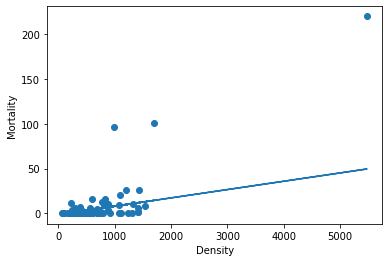

In [61]:
score = linReg('Density', 'Mortality')
score

# Analyzing time

So far, we have not found anything too exciting. In densly populated areas people get infected more often, which seems reasonable. Maybe we can find more interesting patterns when we investigate the temporal and the spatial aspect.

Initially, it seems reasonable to expect the case-number $n$ to follow a logistic model - but we'll see if the data can really support that. 

Logistic growth might look like this:
$$ \frac{dn}{dt} = \alpha n \left( 1 - \frac{n}{n_{tot}} \right) $$

Note that $\alpha$ might depend on $t$, too. It's value will change with the anti-corona meassures taken.

At first we'll assume a constant $\alpha$ for each Landkreis. Then we'll try to evaluate the effectiveness of different models by making $\alpha$ depend on place and meassures.

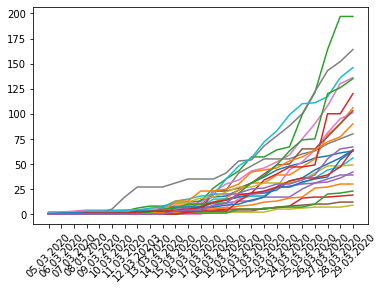

In [32]:
# Inspecting the data
# Note that the timeData uses density-values, that is, 1.000.000 * nrInfections / population

dates = timeData.iloc[2].keys()[2:]
nrSamples = len(dates)
for t in range(nrSamples):
    vals = timeData.iloc[t].values[2:]
    plt.plot(dates, vals)
t = plt.xticks(rotation=45)

In [31]:
timeData["29.03.2020"]

Name_old
Ahrweiler                      63
Aichach-Friedberg             106
Alb-Donau-Kreis               197
Altenburger Land               19
Altenkirchen (Westerwald)      39
                             ... 
Würzburg                      217
Würzburg                      211
Zollernalbkreis               336
Zweibrücken                     9
Zwickau                       286
Name: 29.03.2020, Length: 401, dtype: int64